In [ ]:
!pip install -q kaggle
from google.colab import files
upload = files.upload()

import os

# Make the Kaggle directory
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
# Move the kaggle.json file to the created directory
!cp kaggle.json ~/.kaggle/
# Set permissions for the file
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d bhaveshmittal/melanoma-cancer-dataset

import zipfile

# Ensure the file exists before trying to unzip
if os.path.exists('melanoma-cancer-dataset.zip'):
    with zipfile.ZipFile('melanoma-cancer-dataset.zip', 'r') as zip_ref:
        zip_ref.extractall('data')
else:
    print("Zip file not found!")

!pip install efficientnet-pytorch

import torch
import random
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torch.utils.data import random_split
from efficientnet_pytorch import EfficientNet
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/bhaveshmittal/melanoma-cancer-dataset
License(s): CC0-1.0
 79% 63.0M/79.4M [00:00<00:00, 83.8MB/s]
100% 79.4M/79.4M [00:00<00:00, 90.3MB/s]
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106

In [ ]:
# Define data transformations
data_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
# Load the dataset
dataset = datasets.ImageFolder('data/train', transform=data_transforms)

# Split the dataset into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': train_size, 'val': val_size}
class_names = dataset.classes

print(f"Classes: {class_names}")
print(f"Training dataset size: {dataset_sizes['train']}")
print(f"Validation dataset size: {dataset_sizes['val']}")

Classes: ['Benign', 'Malignant']
Training dataset size: 10691
Validation dataset size: 1188


In [ ]:
class MelanomaModel(nn.Module):
    def __init__(self, out_size, dropout_prob=0.7):
        super(MelanomaModel, self).__init__()
        # Load EfficientNet and remove the classification layer
        self.efficient_net = EfficientNet.from_pretrained('efficientnet-b0')
        self.efficient_net._fc = nn.Identity()  # Remove the original fully connected layer
        self.fc1 = nn.Linear(1280, 512)  # EfficientNet-b3 output features
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, out_size)
        self.dropout = nn.Dropout(dropout_prob) # Dropout layer
        self.loss_fn = nn.CrossEntropyLoss()  # Assuming classification task

    def forward(self, x):
        x = self.efficient_net(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

    def training_step(self, batch):
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        out = self(images)  # Generate predictions
        loss = self.loss_fn(out, labels)  # Calculate loss
        acc = (out.argmax(1) == labels).float().mean()  # Calculate accuracy
        return loss, acc

    def validation_step(self, batch):
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        out = self(images)  # Generate predictions
        loss = self.loss_fn(out, labels)  # Calculate loss
        acc = (out.argmax(1) == labels).float().mean()  # Calculate accuracy
        return {'val_loss': loss.item(), 'val_acc': acc.item()}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = sum(batch_losses) / len(batch_losses)
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = sum(batch_accs) / len(batch_accs)
        return {'val_loss': epoch_loss, 'val_acc': epoch_acc}

    def epoch_end(self, epoch, result, train_loss, train_acc):
        print(f"Epoch [{epoch+1}]")
        print(f"train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f}")
        print(f"val_loss  : {result['val_loss']:.4f}, val_acc  : {result['val_acc']:.4f}")
        print("")

# Instantiate model
num_classes = len(train_dataset.dataset.classes)  # Access the original dataset's classes attribute
model = MelanomaModel(out_size=num_classes, dropout_prob=0.5)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

# Using scheduler
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

# Modify the training loop to include early stopping
def fit(epochs, model, train_loader, val_loader, optimizer, scheduler):
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(epochs):
        model.train()
        train_losses = []
        train_accs = []
        for batch in train_loader:
            loss, acc = model.training_step(batch)
            train_losses.append(loss.item())
            train_accs.append(acc.item())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        train_loss = sum(train_losses) / len(train_losses)
        train_acc = sum(train_accs) / len(train_accs)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        model.eval()
        val_outputs = [model.validation_step(batch) for batch in val_loader]
        result = model.validation_epoch_end(val_outputs)
        history['val_loss'].append(result['val_loss'])
        history['val_acc'].append(result['val_acc'])
        model.epoch_end(epoch, result, train_loss, train_acc)
        scheduler.step()


    return history

# Fit the model with early stopping
history = fit(30, model, train_loader, val_loader, optimizer, scheduler)


Loaded pretrained weights for efficientnet-b0
Epoch [1]
train_loss: 0.3931, train_acc: 0.8219
val_loss  : 0.3276, val_acc  : 0.8586

Epoch [2]
train_loss: 0.3134, train_acc: 0.8669
val_loss  : 0.2552, val_acc  : 0.8882

Epoch [3]
train_loss: 0.2691, train_acc: 0.8844
val_loss  : 0.2461, val_acc  : 0.8988

Epoch [4]
train_loss: 0.2477, train_acc: 0.8996
val_loss  : 0.2098, val_acc  : 0.9120

Epoch [5]
train_loss: 0.2404, train_acc: 0.9010
val_loss  : 0.2164, val_acc  : 0.9062

Epoch [6]
train_loss: 0.2213, train_acc: 0.9090
val_loss  : 0.2085, val_acc  : 0.9128

Epoch [7]
train_loss: 0.2224, train_acc: 0.9060
val_loss  : 0.2022, val_acc  : 0.9178

Epoch [8]
train_loss: 0.2205, train_acc: 0.9079
val_loss  : 0.2015, val_acc  : 0.9178

Epoch [9]
train_loss: 0.2165, train_acc: 0.9060
val_loss  : 0.2022, val_acc  : 0.9145

Epoch [10]
train_loss: 0.2222, train_acc: 0.9069
val_loss  : 0.2080, val_acc  : 0.9153

Epoch [11]
train_loss: 0.2195, train_acc: 0.9097
val_loss  : 0.2093, val_acc  : 0.9

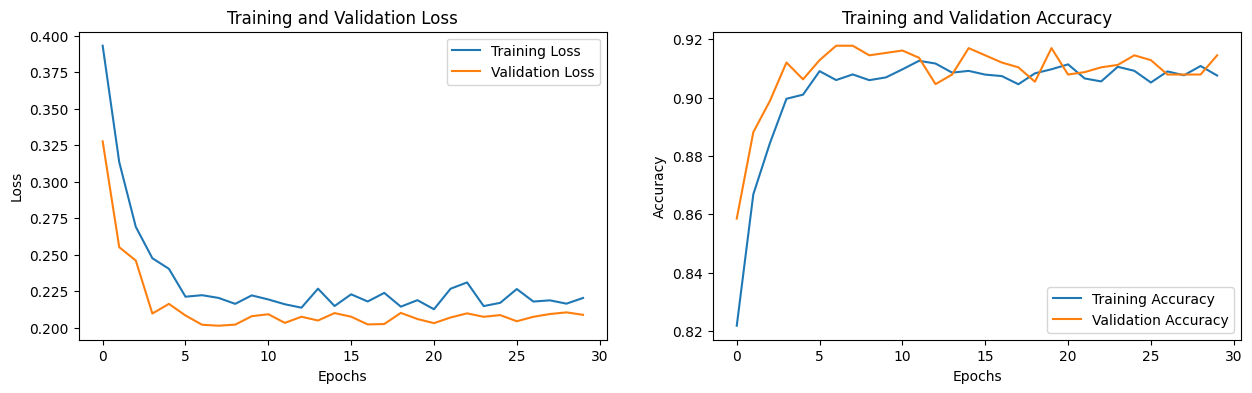

In [ ]:
# Plotting the training and validation loss and accuracy
def plot_history(history):
    epochs = range(len(history['train_loss']))

    plt.figure(figsize=(15, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Training Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.show()

plot_history(history)

In [ ]:
# Save the model weights
torch.save(model.state_dict(), 'trained_weights.pth')

In [ ]:
from google.colab import drive
import torch

# Mount Google Drive
drive.mount('/content/drive')

# Save the model architecture and weights to Google Drive
file_path = '/content/drive/My Drive/model_and_weights.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'architecture': model
}, file_path)

print("Model and weights have been saved to Google Drive:", file_path)


Mounted at /content/drive
Model and weights have been saved to Google Drive: /content/drive/My Drive/model_and_weights.pth


In [ ]:
# Define the test dataset and dataloader
test_dataset = datasets.ImageFolder('data/test', transform=data_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)
class_names = test_dataset.classes

# Function to predict using the loaded model
def predict_image(model, dataloader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    all_acc = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            accuracy = (torch.tensor(all_preds) == torch.tensor(all_labels)).float().mean().item()
            all_acc.append(accuracy)

    accuracy = sum(all_acc) / len(all_acc)
    return all_preds, all_labels, accuracy

# Get predictions, labels, and accuracy for the test set
predictions, labels, accuracy = predict_image(model, test_loader, device, class_names)

# Print predictions with original labels
for idx, (pred, label) in enumerate(zip(predictions, labels)):
    print(f"Image {idx}: Real label: {class_names[label]}, Predicted class: {class_names[pred]}")

print(f"Test Accuracy: {accuracy:.4f}")

Image 0: Real label: Benign, Predicted class: Benign
Image 1: Real label: Benign, Predicted class: Benign
Image 2: Real label: Benign, Predicted class: Benign
Image 3: Real label: Benign, Predicted class: Malignant
Image 4: Real label: Benign, Predicted class: Benign
Image 5: Real label: Benign, Predicted class: Benign
Image 6: Real label: Benign, Predicted class: Benign
Image 7: Real label: Benign, Predicted class: Benign
Image 8: Real label: Benign, Predicted class: Benign
Image 9: Real label: Benign, Predicted class: Benign
Image 10: Real label: Benign, Predicted class: Benign
Image 11: Real label: Benign, Predicted class: Benign
Image 12: Real label: Benign, Predicted class: Benign
Image 13: Real label: Benign, Predicted class: Benign
Image 14: Real label: Benign, Predicted class: Benign
Image 15: Real label: Benign, Predicted class: Benign
Image 16: Real label: Benign, Predicted class: Benign
Image 17: Real label: Benign, Predicted class: Benign
Image 18: Real label: Benign, Predi

In [ ]:
test_image = datasets.ImageFolder('data/test')

Randomly selected image 1119:


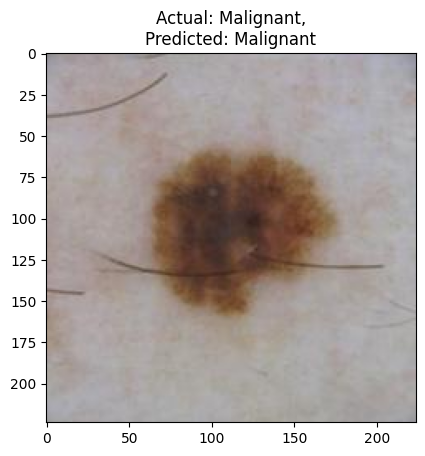

1


In [ ]:
# Choose a random index
random_idx = random.randint(0, len(predictions) - 1)

# Get the predicted and actual label
pred_label = class_names[predictions[random_idx]]
actual_label = class_names[labels[random_idx]]

print(f"Randomly selected image {random_idx}:")

img , label = test_image[random_idx]
plt.imshow(img)
plt.title(f"Actual: {actual_label},\nPredicted: {pred_label}")
plt.show()
print(label)